**NOTE** Run all cells in section 2, then skip to sections 5 for data loading (all preprocessing is done) and modeling helpers. Then, be sure to run the first cell in each other section to ensure the data is formatted correctly for that model type

# Business Problem

Pneumonia is a common infection that causes inflammation and possible fluid accumulation in the air sacs of the lungs. In China, pneumonia is one of the leading causes of death for [children under 5 years old](https://journals.lww.com/md-journal/Fulltext/2018/11160/The_drug_use_to_treat_community_acquired_pneumonia.42.aspx#:~:text=More%20than%202%20million%200,the%20age%20of%205%20years.) The infection is commonly caused by bactria and viruses, but can also be caused by fungal sources. 

Pediatric pneumonia is initially diagnosed based on the [time of the year and the results of a physical exam](https://www.nationwidechildrens.org/conditions/pneumonia), paying attention the child's breathing and listening to the lungs. Physical symptoms associated with pneumonia generally include fever, rapid breathing, and increased heart rate. A further step in diagnosis would be to use chest X-rays; pneumonia is not always seen on x-rays, either because [the disease is in its initial stages or it involves a part of the lung not easily seen by X-ray.](https://www.wikidoc.org/index.php/Pneumonia_chest_x_ray). Inconclusive initial testing can result in additional blood tests to confirm or rule out the presence of infection.


As we can see, even with modern medicine pneumonia can be misdiagnosed. Not all pneumonia infections are treated in the same way; viral infections cannot be fought with the same antibiotics that would treat a bacterial infection. A fast and accurate diagnosis allows doctors to treat the infection with the appropirate care. One application of machine learning in medicine is digital diagnosis. We have been tasked with developing an identification model to determine if a chest X-ray indicates the presence of pneumonia. False negative results are to be minimized compared to false positives.

The data is sourced from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It is already split into three folders for training, validation and testing. All the chest radiographs were screened for quality and diagnostic labeling performed by physicians. The images were collected during routine clinicial care of pediatric patients between one and five years old from Guangzhou Women and Children's Medical Center in Guangzhou, China.

# Imports

In [1]:
import os
from os import listdir
from os.path import isfile, join
import tempfile

from PIL import Image
import math

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

In [2]:
# os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict
# set figsize for matplotlib
mpl.rcParams['figure.figsize'] = (12, 10)
# set colors for plots
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# EDA

## Helper Functions

Helper functions:
- get_ratio: return the ratio of an 2D image array width:height
- resize_and_crop: returns a scaled and cropped image

In [ ]:
def get_ratio(array):
    return array.shape[0]/array.shape[1]

def resize_and_crop(image, new_size=256):
    """
    This function will take in an image, resize and crop it to a square.
    The default new length for a side is 256 pixels.
    The function will output a new square, centered image.
    
    """
    # get width and height from passed image   
    width, height = image.size
    # set up variables for new width and height
    new_width = 0
    new_height = 0
    # calculate the ratio and length of the smaller dimension if the larger moves to the new_size
    if width > height:
        ratio_wh = width / height
        new_width = int(ratio_wh * new_size)
        new_height = new_size
    else:
        ratio_hw = height / width
        new_width = new_size
        new_height = int(ratio_hw * new_size)
    # resize the image
    scaled_image = image.resize((new_width, new_height))
    # if the image is wider, crop in equally from the sides to preserve center of image
    # perform the opposite on images that are taller
    if new_width > new_height:
        # we are only cropping in from left and right, so set top crop to 0 and bottom to new_size
        top = 0
        bottom = new_size
        # set the left and right side crop values
        left = int(math.ceil((new_width - new_size) / 2))
        right = new_width - int(math.floor((new_width - new_size) / 2))
        # crop the image
        cropped_image = scaled_image.crop((left, top, right, bottom))
    else:
        # we are only cropping top and bottom, so set left crop to 0 and right crop to new_size
        left = 0
        right = new_size
        # set the top and bottom crop values
        top = int(math.ceil((new_height - new_size) / 2))
        bottom = new_height - int(math.floor((new_height - new_size) / 2))
        # save the cropped image
        cropped_image = scaled_image.crop((left, top, right, bottom))
    # return the scaled and cropped image
    return cropped_image

## Image size

First, we are going to build a dataframe that contains all the image information for us to look at image sizes.

In [ ]:
folder_names = ['train', 'test', 'val']
label_names = ['NORMAL', 'PNEUMONIA']

all_images = []

# loop through the different combinations of folder name prefixes
for folder in folder_names:
    for label in label_names:
        # set up the path to each folder of images
        path = f'./chest_xray/{folder}/{label}'
        # create a list of the filenames in that directory
        filelist = list(listdir(path))
        # loop through each file in the folder
        for file_name in filelist:
            # set the filepath for the file in question
            filepath = path + r'/' + file_name
            # open the image
            image = Image.open(filepath)
            # save the image mode
            img_mode = image.mode
            # get the width and heigh of the image
            width, height = image.size
            # calculate the dimension ratio
            ratio = height / width
            # append the image infromation to the list all_images
            all_images.append((folder, label, file_name, img_mode, ratio, width, height))

# set the column names
column_names = ['folder', 'label', 'file_name', 'img_mode','ratio', 'width', 'height']
# convert the list of images to a dataframe
all_images_df = pd.DataFrame(all_images, columns=column_names)

In [ ]:
all_images_df.head()

In [ ]:
all_images_df.img_mode.value_counts()

So it looks like despite our images being in black and white, we have 283 images that are coded as RGB images. We will need to convert them before making our image arrays otherwise our shapes will not match. Lets look at the sizes of our images.

In [ ]:
all_images_df.describe()

We have a wide variety of image sizes. For best results in modeling it was advised to scale images to 256x256. We can see that there are some images whose height is below our minimum, lets look a little closer.

In [ ]:
small_images_df = all_images_df[all_images_df.height < 256].copy()

In [ ]:
small_image_count = len(small_images_df)

print(f'There are {small_image_count} images with a dimension under 256.')
print('-------------------------------')
print('Small images occur in the following data/labels:')
display(all_images_df[all_images_df.height < 256].folder.value_counts())
display(all_images_df[all_images_df.height < 256].label.value_counts())

In [ ]:
print('Target distribution in training data')
round(all_images_df[all_images_df.folder == 'train'].label.value_counts(normalize=True)*100, 2)

In [ ]:
percent_small = round(small_image_count / len(all_images_df[(all_images_df.label == "PNEUMONIA") & (all_images_df.folder == 'train')]), 2)
print(f'The {small_image_count} small images represent {percent_small}% of our training data with the pneumonia label')

In [ ]:
small_images_df.ratio.plot(kind='hist');

We can see here that there are only 58 images out of our total 5856 which have a dimension less than our minimum. They are all from training images positive with pneumonia, where we have a large imbalance of that data. Additionally, the ratios of these images are small, meaning that they are significantly wider than they are tall. This would also pose a problem as our images are chest x-rays, and those wider images would likely get cut off when we resize them to square. 

We will not consider these images in modeling so we will drop them from the dataframe.

In [ ]:
images_df = all_images_df.drop(small_images_df.index)
images_df.reset_index(drop=True, inplace=True)

__________________

Since we discovered that the smaller images had very low ratios, let's consider the ratios of the all the rest of the images.

In [ ]:
images_df.ratio.describe()

In [ ]:
images_df.ratio.plot(kind='hist');

Most of our images (75%) have a ratio above 0.63, but the minimum is very low at 0.38. It's suspected that cropping the images that we have with low ratio (which indicates very wide images) may be problematic, so it may be something we have to return to and consider dropping some images with a ratio below a certain threshold. We can do some quick investigation into that.

## Cropping

In [ ]:
def compare_cropping(index_value, df=images_df):
    """
    This helper function will take in the index value of an image in the default
    dataframe: all_images_df. It will display the width, height, and ratio of the
    original with the original image. It will then perform the cropping and display
    the new imaged data along with the new cropped image for comparison.   
    """
    # Get the folder and img_type value from the dataframe to contsruct the folder root
    folder = df.iloc[index_value]['folder']
    label = df.iloc[index_value]['label']
    # constrcut the folder root for the file in question
    root=f"./chest_xray/{folder}/{label}/"
    # set the image path and open the image
    image_path = root + df.iloc[index_value]['file_name']
    image = Image.open(image_path)
    # print the dimensions, ratio, and original image
    print(f"width: {image.width}\theight: {image.height}\tratio: {image.height/image.width}")
    display(image)
    # crop the image
    cropped_image = resize_and_crop(image)
    # print the new image (will be 256x256 with ratio of 1.0)
    display(cropped_image)

Let's look at an image with our 25th percentile value for ratio: 0.63

In [ ]:
compare_cropping(images_df[images_df.ratio == 0.63].index[0])

Here we can see we are losing some of our image on the sides of the chest cavity. We know that data is expensive, so we want to use the most of our images that we can. For arguments' sake, if we were willing to lose the worst 5% of our images based on ratio, let's examine an image with the ratio of the 5% quantile.

In [ ]:
images_df.quantile(q=0.05)

In [ ]:
compare_cropping(images_df[images_df.ratio == 0.55].index[0])

We are definitely losing data by cropping images with ratios this low. Out of curiosity, let's see where most of these images are.

In [ ]:
images_df[images_df.ratio <= 0.55].folder.value_counts()

In [ ]:
images_df[images_df.ratio <= 0.55].label.value_counts()

If we see impact during modeling, we may consider dropping images with ratios less than 0.55 from consideration. Most of the images are from our training set of positive cases (which we have a large majority of).

# Image Preprocessing

Now that we have a dataframe of the raw images data, we need to resize, shrink and convert the images to arrays for modeling. We will do that with a helper function applied to the dataframe and input the arrays into a new feature called 'image_array'.

In [ ]:
def create_image_array(df):
    # set path for image
    path = path = f'./chest_xray/{df.folder}/{df.label}/{df.file_name}'
    # open image
    image = Image.open(path)
    # convert to greyscale
    if image.mode == 'RGB':
        image = image.convert('L')
    # resize and crop the image
    image_modified = resize_and_crop(image)
    # return the image as a numpy array
    return np.asarray(image_modified)

images_df['image_array'] = images_df.apply(create_image_array, axis=1)

We also need to convert the label to a binary value for our target.

In [ ]:
def create_target(df):
    if df.label == 'PNEUMONIA':
        return 1
    else:
        return 0
    
images_df['target'] = images_df.apply(create_target, axis=1)

Now we can set a dataframe for each of our three datasets (train, test and validation)

In [ ]:
train_df = images_df[images_df.folder == 'train'][['image_array', 'target']]
test_df = images_df[images_df.folder == 'test'][['image_array', 'target']]
val_df = images_df[images_df.folder == 'val'][['image_array', 'target']]

Then we split the image_array and target apart, save each datasets' X and y, shuffle the data, and check the shape of each array.

In [ ]:
X_train = np.array(train_df.image_array.values.tolist())
y_train = np.asarray(train_df.target)

X_test = np.array(test_df.image_array.values.tolist())
y_test = np.asarray(test_df.target)

X_val = np.array(val_df.image_array.values.tolist())
y_val = np.asarray(val_df.target)

# helper function to shuffle data/target in the same way
def shuffle_arrays(data, target):
    assert len(data) == len(target)
    p = np.random.permutation(len(data))
    return data[p], target[p]
# shuffle all data
X_train, y_train = shuffle_arrays(X_train, y_train)
X_val, y_val = shuffle_arrays(X_val, y_val)
X_test, y_test = shuffle_arrays(X_test, y_test)

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

In [ ]:
# set the data path
data_path = f"./data/"
# list of variables we are saving
datasets = ['X_train', 'y_train', 'X_test', 'y_test', 'X_val', 'y_val']

for dataset in datasets:
    np.save(file=f'{data_path}{dataset}.npy', arr=globals()[dataset])

# Data Loading

In [3]:
# set the data path and get the list of files
data_path = f"./data/"
data_files = list(listdir(data_path))

for file in data_files:
    # split off the components of the file name
    dataset = file[:-4]
    # set a global variable for each file with that files name and the data from the file
    globals()[f"{dataset}"] = np.load(data_path + file)

# set the data types to floa
X_train_orig = X_train.astype('float32')
X_val_orig = X_val.astype('float32')
X_test_orig = X_test.astype('float32')

# normalize the data
X_train_orig /= 255.
X_val_orig /= 255.
X_test_orig /= 255.

# verify shapes are accurate
print(f"Train data/target shapes: {X_train_orig.shape}, {y_train.shape}")
print(f"Val data/target shapes: {X_val_orig.shape}, {y_val.shape}")
print(f"Test data/target shapes: {X_test_orig.shape}, {y_test.shape}")

Train data/target shapes: (5158, 256, 256), (5158,)
Val data/target shapes: (16, 256, 256), (16,)
Test data/target shapes: (624, 256, 256), (624,)


# Modeling helpers

## Global Variables

In [4]:
# setting up training data class imbalance for eventual weighting
neg, pos = np.bincount(y_train)
total = neg+pos

percent_neg = round(neg/total*100, 2)
percent_pos = round(pos/total*100, 2)

print(f'Training data contains:\nTotal: {total}\nNegative: {neg} ({percent_neg}%)\nPositive: {pos} ({percent_pos}%)')

Training data contains:
Total: 5158
Negative: 1341 (26.0%)
Positive: 3817 (74.0%)


In [5]:
# setting up metrics for model comparison
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'), # using binary accuracy
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [6]:
# set up the class weights using y_train
classes = list(np.unique(y_train))
weights = list(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train))
class_weights = dict(zip(classes, weights))
class_weights

{0: 1.9231916480238629, 1: 0.675661514278229}

## Helper Functions

In [7]:
def set_x_y():
    # get user input for testing dataset
    print("Choose which testing dataset to use for reporting")
    print("Input S for training data\nInput T for test data\nInput V for validation data:")
    test_choice = input()
    # set the correct global datasets to the local X_test and y_test for reporting
    if test_choice.lower() == 's':
        X_test, y_test = globals()['X_train'], globals()['y_train']
    elif test_choice.lower() == 't':
        X_test, y_test = globals()['X_test'], globals()['y_test']
    else:
        X_test, y_test = globals()['X_val'], globals()['y_val']
    # return the test target and label
    return X_test, y_test

def converted_ypred(model, X_test, threshold=0.5):
    # generate predictions
    y_pred = model.predict(X_test)
    # convert the predictions based on the threshold
    # default is: 0.5
    converted_ypred = []
    for i in range(len(y_pred)):
        if y_pred[i][0] > threshold:
            converted_ypred.append(1)
        else:
            converted_ypred.append(0)
    # return the converted y_preds as an array
    return np.asarray(converted_ypred)

def model_report(y_test, y_pred):
    # set up labels for classifcation report and confution matrix
    report_labels = ['normal', 'pneumonia']
    column_labels = ['predicted normal', 'predicted pneumonia']
    index_labels = ['actual normal', 'actual pneumonia']
    # generate the confusion matrix
    cmatrix = confusion_matrix(y_test, y_pred)
    # convert into dataframe
    cmatrix_df = pd.DataFrame(cmatrix, columns=column_labels, index=index_labels)
    print('---------------------------------------------------------------\n')
    # print the classification report
    print(classification_report(y_test, y_pred, zero_division=0, target_names=report_labels))
    # show report as heatmap   
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(data=cmatrix_df, annot=True, cmap='Blues', fmt='g')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

def plot_metrics(results):
    # set the history
    history = results.history
    # set up metrics to plot
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    # set up x-axis (number of epochs)
    epochs = list(range(1, len(history['loss'])+1))
    # generate plot for each of the 4 metrics in a 2x2 plot
    plt.figure(figsize=(15,15))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(epochs, history[metric], color=colors[0], label='Train')
        plt.plot(epochs, history['val_'+metric], color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0,1.1])
    plt.legend();    

def full_report(model, results):
    # set the X_train and y_train
    X_train, y_train = globals()['X_train'], globals()['y_train']
    # set the testing X and y based on input
    X_test, y_test = set_x_y()
    # create the y_pred 
    y_pred = converted_ypred(model, X_test)   
    # print the model report and confusion matrix
    model_report(y_test, y_pred)
    # display the 2x2 plot of metrics  
    plot_metrics(results)

# Baseline

### Correcting data shape

In [ ]:
# set the lengths of each set of data
train_len = X_train_orig.shape[0]
test_len = X_test_orig.shape[0]
val_len = X_val_orig.shape[0]

# set the new reshape size for the images
img_size = X_train_orig.shape[1] ** 2

# reshape all three data groups
X_train = X_train_orig.reshape(train_len, img_size).astype('float32')
X_test = X_test_orig.reshape(test_len, img_size).astype('float32')
X_val = X_val_orig.reshape(val_len, img_size).astype('float32')

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

## MLP model

Inspiration from TensorFlow Tutorial to enact some changes to process and account for imbalanced data. [Source](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [ ]:
def make_baseline_model():
       
    # set up model
    model = keras.Sequential()
    model.add(Dense(128, activation='relu', input_shape = (X_train.shape[-1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=METRICS)

    return model

In [ ]:
baseline_model = make_baseline_model()
baseline_model.summary()

In [ ]:
EPOCHS = 5
BATCH_SIZE = 30

baseline_results = baseline_model.fit(X_train, y_train,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      class_weight=dict(enumerate(class_weights)),
                                      validation_data=(X_val, y_val))

In [ ]:
full_report(baseline_model, baseline_results)

This doesn't look great. Our model accuracy is at 74% and steady, and the validation is at 50%. Unsurprisingly, these are the percentages of our data that are labeled with pneumonia (74% for training, 50% for validation). 

# CNN

### Correcting data shape

In [8]:
# set up the X train/test/val for CNNs
X_train = X_train_orig.reshape(len(X_train_orig), 256, 256, 1)
X_val = X_val_orig.reshape(len(X_val_orig), 256, 256, 1)
X_test = X_test_orig.reshape(len(X_test_orig), 256, 256, 1)

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

Train data/target shapes: (5158, 256, 256, 1), (5158,)
Test data/target shapes: (624, 256, 256, 1), (624,)
Val data/target shapes: (16, 256, 256, 1), (16,)


### Callbacks

In [27]:
# we are going to employ a patience of 2 for early stopping
CALLBACKS = [
    EarlyStopping(patience=2),
    
    ModelCheckpoint(filepath='model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min'
                                   )
]

### Hyperparameter Defaults

To ensure we are only changing particular hyperparameters at a time, we will set defaults to be used in model building.
- The input shape is set correct for our images size (256, 256, 1).
- Default epochs will be 25, using early stopping this should be fine.
- Default batch size will be 128.
- Default layer activation will use 'relu'
- Default output activation will use 'sigmoid'
- Default loss will use binary crossentropy 
- Default optimizer will use 'adam'.
- The list of metrics was defined in section 6.1

In [81]:
# set the default input shape to (256, 256, 1)
INPUT_SHAPE = (256, 256, 1)

# set the default epoch length to 10
EPOCHS = 25

# set the default batch_size to 128
BATCH_SIZE = 128

# set the default layer activation to 'relu'
ACTIVATION = 'relu'

# set the default output activation to 'sigmoid'
OUTPUT = 'sigmoid'

# set the default loss to 'binary crossentropy'
LOSS = 'binary_crossentropy'

# set the default optimizer to 'adam'
OPTIMIZER = 'adam'

## CNN model v1

For the first CNN model, we will use 3 layers of convolution, starting with 32 filters and doubling each layer.

In [44]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v1 = make_cnn_model()
cnn_model_v1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 30, 128)     

In [30]:
cnn_model_v1_results = cnn_model_v1.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.4310 - tp: 3414.0000 - fp: 594.0000 - tn: 755.0000 - fn: 411.0000 - accuracy: 0.8058 - precision: 0.8518 - recall: 0.8925 - auc: 0.8524 - prc: 0.9246
Epoch 1: val_loss improved from inf to 0.58550, saving model to model.epoch01-loss0.59.hdf5
41/41 [==============================] - 189s 5s/step - loss: 0.4310 - tp: 3414.0000 - fp: 594.0000 - tn: 755.0000 - fn: 411.0000 - accuracy: 0.8058 - precision: 0.8518 - recall: 0.8925 - auc: 0.8524 - prc: 0.9246 - val_loss: 0.5855 - val_tp: 8.0000 - val_fp: 3.0000 - val_tn: 5.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 0.8984 - val_prc: 0.8949
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1620 - tp: 3674.0000 - fp: 183.0000 - tn: 1158.0000 - fn: 143.0000 - accuracy: 0.9368 - precision: 0.9526 - recall: 0.9625 - auc: 0.9777 - prc: 0.9907
Epoch 2: val_loss improved from 0.58550 to 0.27523, saving

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.91      0.46      0.61       234
   pneumonia       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



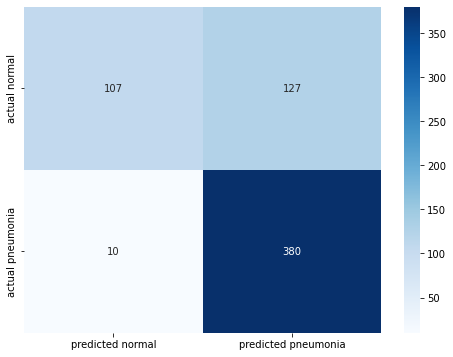

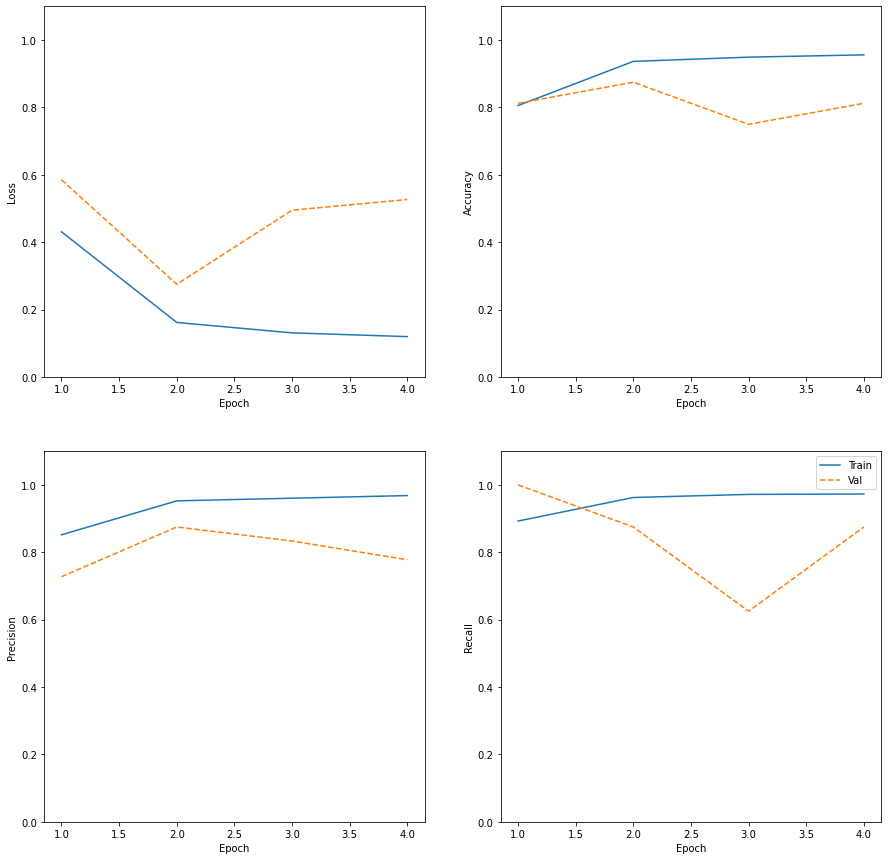

In [31]:
full_report(cnn_model_v1, cnn_model_v1_results)

## CNN model v2

Adding another convolution layer with 64 filters

In [45]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v2 = make_cnn_model()
cnn_model_v2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 30, 30, 64)      

In [33]:
cnn_model_v2_results = cnn_model_v2.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.4566 - tp: 3617.0000 - fp: 878.0000 - tn: 471.0000 - fn: 208.0000 - accuracy: 0.7901 - precision: 0.8047 - recall: 0.9456 - auc: 0.7817 - prc: 0.9051
Epoch 1: val_loss did not improve from 0.27523
41/41 [==============================] - 180s 4s/step - loss: 0.4566 - tp: 3617.0000 - fp: 878.0000 - tn: 471.0000 - fn: 208.0000 - accuracy: 0.7901 - precision: 0.8047 - recall: 0.9456 - auc: 0.7817 - prc: 0.9051 - val_loss: 0.3402 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 6.0000 - val_fn: 1.0000 - val_accuracy: 0.8125 - val_precision: 0.7778 - val_recall: 0.8750 - val_auc: 0.9219 - val_prc: 0.9398
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1656 - tp: 3667.0000 - fp: 180.0000 - tn: 1161.0000 - fn: 150.0000 - accuracy: 0.9360 - precision: 0.9532 - recall: 0.9607 - auc: 0.9779 - prc: 0.9918
Epoch 2: val_loss did not improve from 0.27523
41/41 [==============================] - 181s 4s/step - loss

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.92      0.35      0.51       234
   pneumonia       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.67       624
weighted avg       0.79      0.75      0.71       624



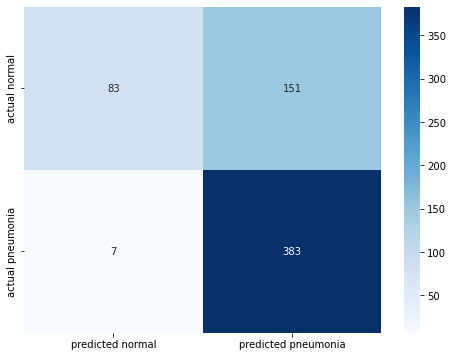

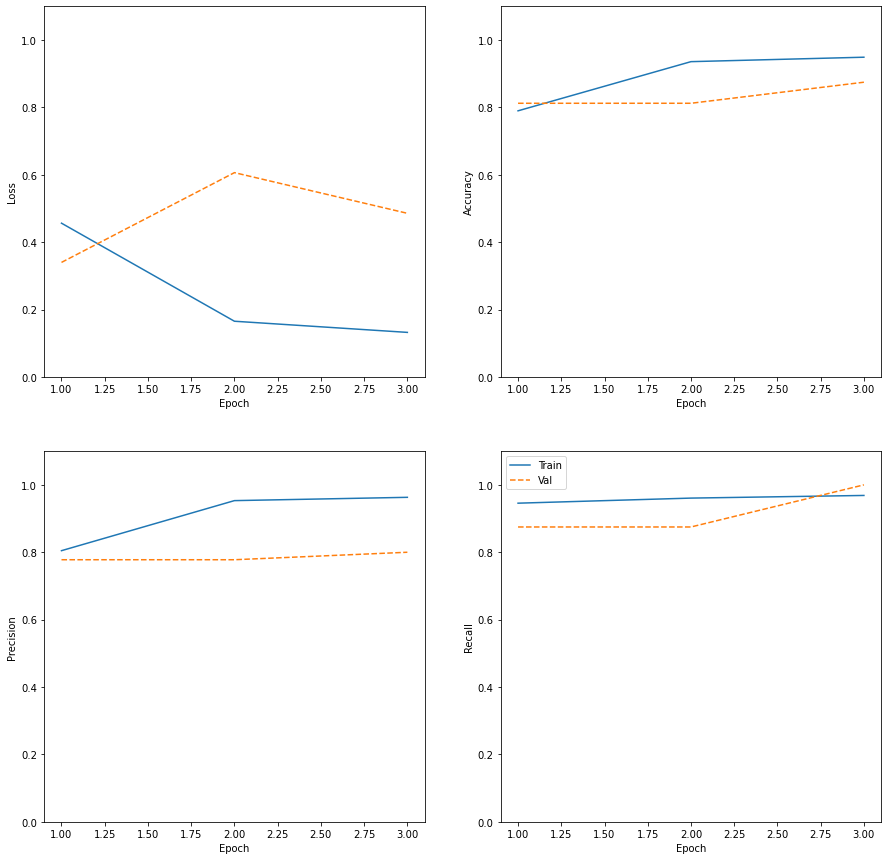

In [34]:
full_report(cnn_model_v2, cnn_model_v2_results)

## CNN model v3

Adding in class weighting (calculated in 6.1)

In [46]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v3 = make_cnn_model()
cnn_model_v3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 30, 30, 64)     

In [36]:
cnn_model_v3_results = cnn_model_v3.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.5390 - tp: 2325.0000 - fp: 203.0000 - tn: 1146.0000 - fn: 1500.0000 - accuracy: 0.6709 - precision: 0.9197 - recall: 0.6078 - auc: 0.8259 - prc: 0.9086
Epoch 1: val_loss did not improve from 0.27523
41/41 [==============================] - 186s 4s/step - loss: 0.5390 - tp: 2325.0000 - fp: 203.0000 - tn: 1146.0000 - fn: 1500.0000 - accuracy: 0.6709 - precision: 0.9197 - recall: 0.6078 - auc: 0.8259 - prc: 0.9086 - val_loss: 0.2792 - val_tp: 6.0000 - val_fp: 1.0000 - val_tn: 7.0000 - val_fn: 2.0000 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500 - val_auc: 0.9531 - val_prc: 0.9570
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1933 - tp: 3520.0000 - fp: 95.0000 - tn: 1246.0000 - fn: 297.0000 - accuracy: 0.9240 - precision: 0.9737 - recall: 0.9222 - auc: 0.9771 - prc: 0.9915
Epoch 2: val_loss did not improve from 0.27523
41/41 [==============================] - 184s 4s/step - l

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.95      0.32      0.48       234
   pneumonia       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.65       624
weighted avg       0.80      0.74      0.70       624



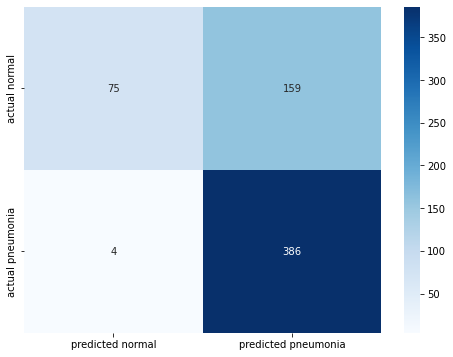

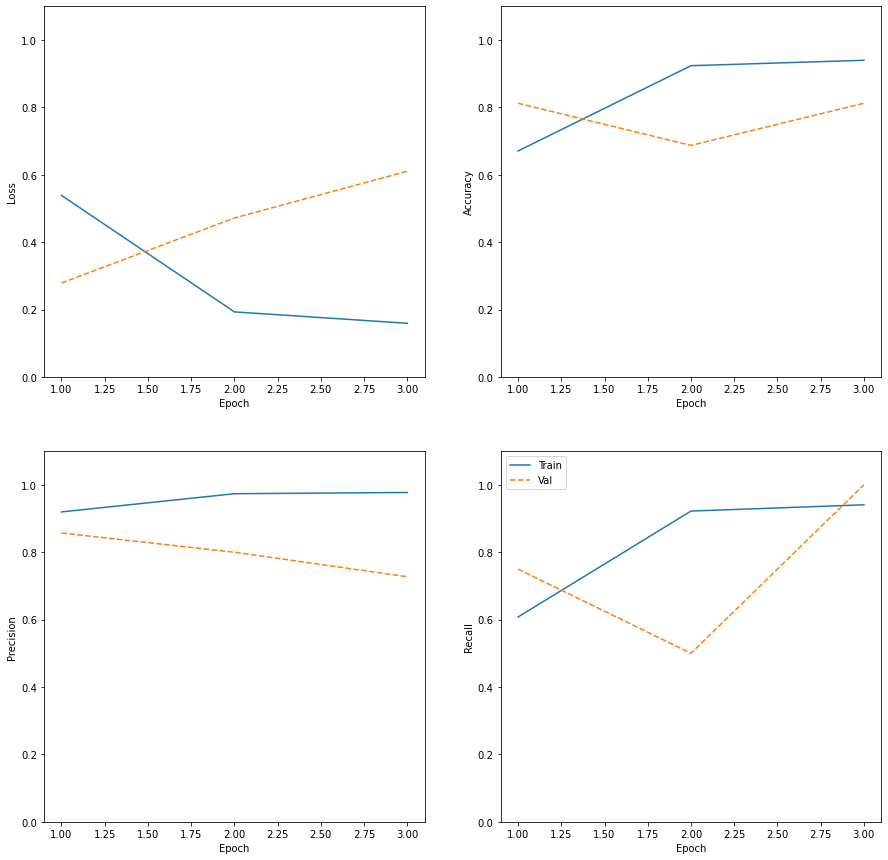

In [37]:
full_report(cnn_model_v3, cnn_model_v3_results)

## CNN Model v4

Change the optimizer to RMSProp with a learning rate of 0.01

In [47]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=keras.optimizers.RMSprop(0.01),
                  metrics=METRICS)

    return model

cnn_model_v4 = make_cnn_model()
cnn_model_v4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 30, 30, 64)     

In [39]:
cnn_model_v4_results = cnn_model_v4.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 229.8845 - tp: 1768.0000 - fp: 625.0000 - tn: 724.0000 - fn: 2057.0000 - accuracy: 0.4816 - precision: 0.7388 - recall: 0.4622 - auc: 0.4958 - prc: 0.7333
Epoch 1: val_loss did not improve from 0.27523
41/41 [==============================] - 177s 4s/step - loss: 229.8845 - tp: 1768.0000 - fp: 625.0000 - tn: 724.0000 - fn: 2057.0000 - accuracy: 0.4816 - precision: 0.7388 - recall: 0.4622 - auc: 0.4958 - prc: 0.7333 - val_loss: 0.6951 - val_tp: 8.0000 - val_fp: 8.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.6935 - tp: 2715.0000 - fp: 965.0000 - tn: 376.0000 - fn: 1102.0000 - accuracy: 0.5993 - precision: 0.7378 - recall: 0.7113 - auc: 0.4986 - prc: 0.7404
Epoch 2: val_loss did not improve from 0.27523
41/41 [==============================] - 174s 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.38      1.00      0.55       234
   pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



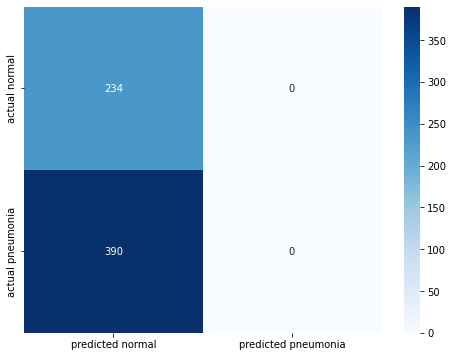

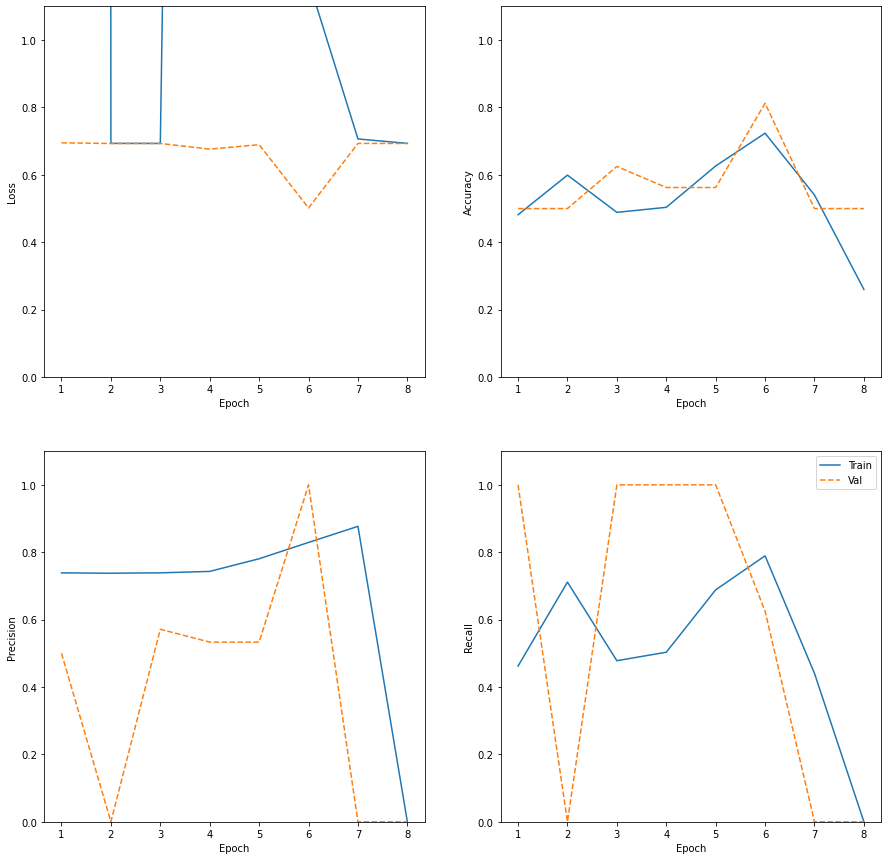

In [40]:
full_report(cnn_model_v4, cnn_model_v4_results)

## CNN model v5

Decrease the learning rate by a factor of 10.

In [48]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=keras.optimizers.RMSprop(0.001),
                  metrics=METRICS)

    return model

cnn_model_v5 = make_cnn_model()
cnn_model_v5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 30, 30, 64)     

In [42]:
cnn_model_v5_results = cnn_model_v5.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.7927 - tp: 2502.0000 - fp: 500.0000 - tn: 849.0000 - fn: 1323.0000 - accuracy: 0.6477 - precision: 0.8334 - recall: 0.6541 - auc: 0.6664 - prc: 0.8181
Epoch 1: val_loss did not improve from 0.27523
41/41 [==============================] - 192s 5s/step - loss: 0.7927 - tp: 2502.0000 - fp: 500.0000 - tn: 849.0000 - fn: 1323.0000 - accuracy: 0.6477 - precision: 0.8334 - recall: 0.6541 - auc: 0.6664 - prc: 0.8181 - val_loss: 0.5493 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 5.0000 - val_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.3750 - val_auc: 0.9375 - val_prc: 0.9565
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.4950 - tp: 3325.0000 - fp: 254.0000 - tn: 1087.0000 - fn: 492.0000 - accuracy: 0.8554 - precision: 0.9290 - recall: 0.8711 - auc: 0.8964 - prc: 0.9279
Epoch 2: val_loss did not improve from 0.27523
41/41 [==============================] - 195s 5s/step 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.56      0.24      0.34       234
   pneumonia       0.66      0.88      0.76       390

    accuracy                           0.64       624
   macro avg       0.61      0.56      0.55       624
weighted avg       0.62      0.64      0.60       624



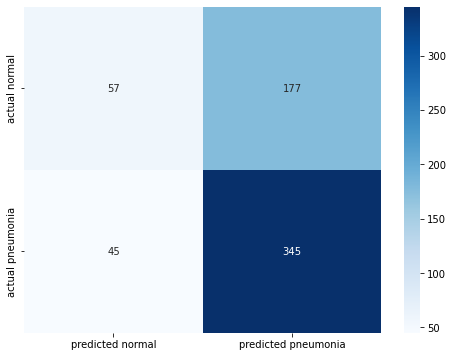

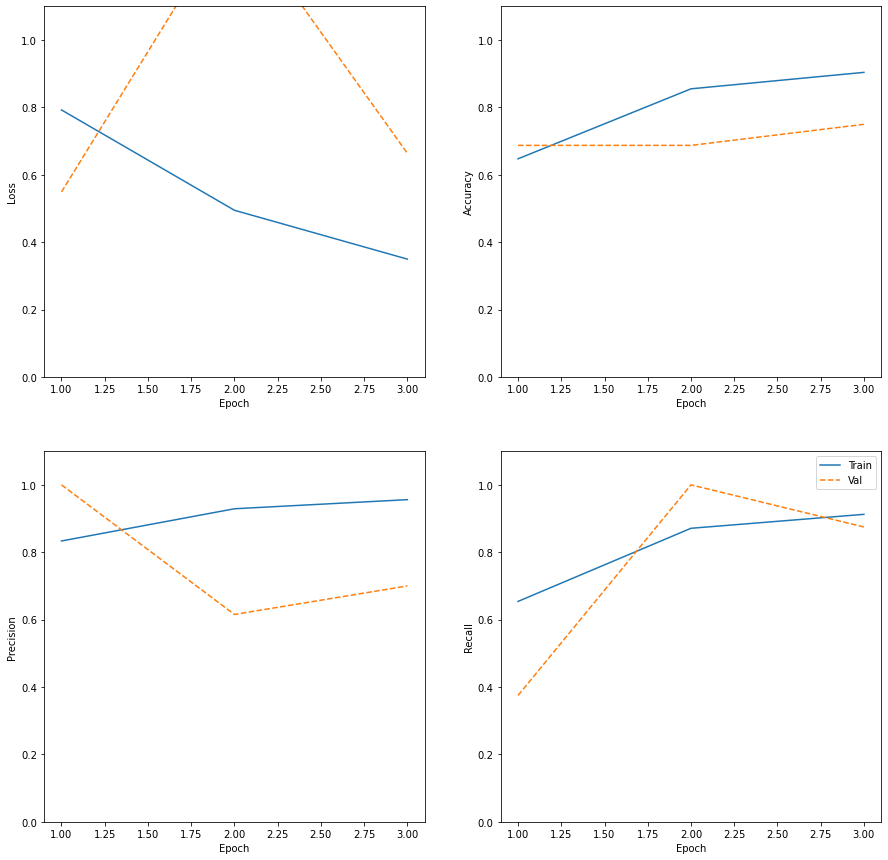

In [49]:
full_report(cnn_model_v5, cnn_model_v5_results)

## CNN model v6

So far our implemented changes have resulted in worse performing models than our first model.

We are going to go back to that and change filters on the convolutional layers, decreasing each by half.

In [50]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

    return model

cnn_model_v6 = make_cnn_model()
cnn_model_v6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 30, 30, 64)     

In [51]:
cnn_model_v6_results = cnn_model_v6.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.5177 - tp: 2706.0000 - fp: 235.0000 - tn: 1114.0000 - fn: 1119.0000 - accuracy: 0.7383 - precision: 0.9201 - recall: 0.7075 - auc: 0.8458 - prc: 0.9142
Epoch 1: val_loss improved from 0.27523 to 0.27397, saving model to model.epoch01-loss0.27.hdf5
41/41 [==============================] - 106s 3s/step - loss: 0.5177 - tp: 2706.0000 - fp: 235.0000 - tn: 1114.0000 - fn: 1119.0000 - accuracy: 0.7383 - precision: 0.9201 - recall: 0.7075 - auc: 0.8458 - prc: 0.9142 - val_loss: 0.2740 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 7.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000 - val_auc: 0.9844 - val_prc: 0.9853
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1837 - tp: 3526.0000 - fp: 95.0000 - tn: 1246.0000 - fn: 291.0000 - accuracy: 0.9252 - precision: 0.9738 - recall: 0.9238 - auc: 0.9797 - prc: 0.9927
Epoch 2: val_loss did not improve from 0.27397
41/4

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.89      0.50      0.64       234
   pneumonia       0.76      0.96      0.85       390

    accuracy                           0.79       624
   macro avg       0.82      0.73      0.74       624
weighted avg       0.81      0.79      0.77       624



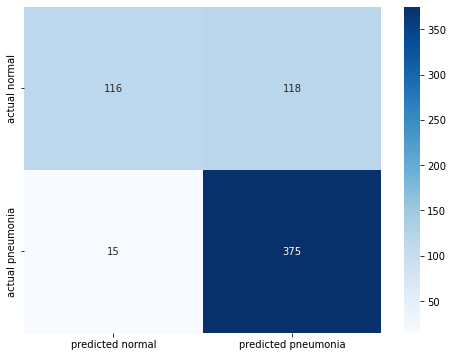

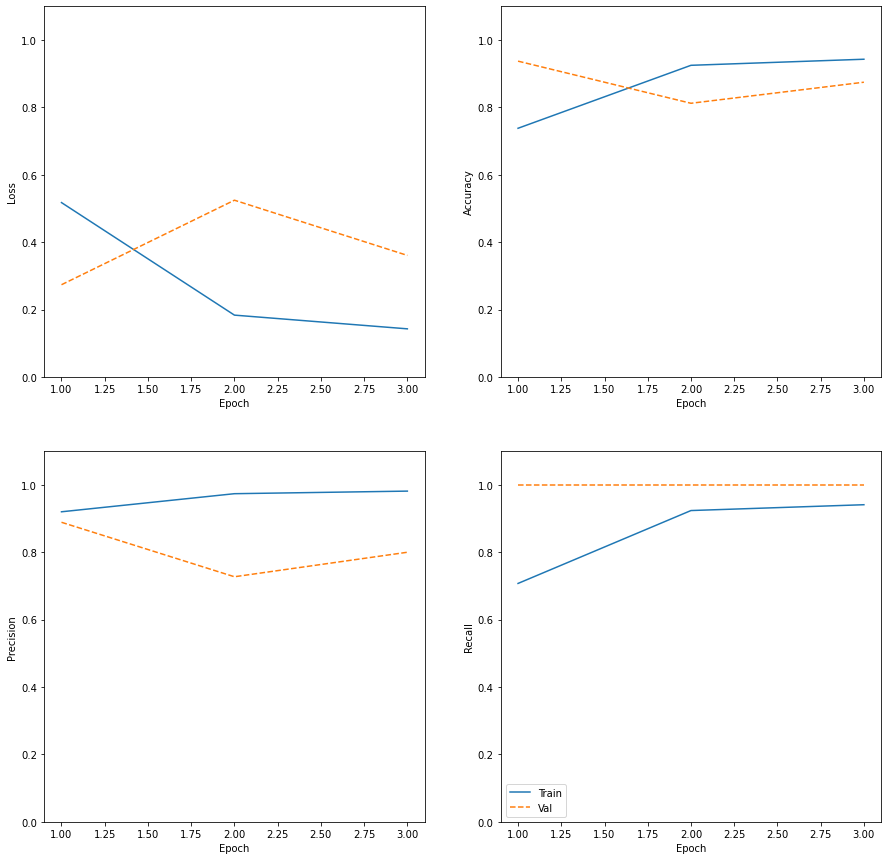

In [52]:
full_report(cnn_model_v6, cnn_model_v6_results)

## CNN model v7

Lets add in a 4th convolutional layer, duplicating the middle layer with 32 filters.

In [53]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v7 = make_cnn_model()
cnn_model_v7.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 30, 30, 32)     

In [54]:
cnn_model_v7_results = cnn_model_v7.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.4416 - tp: 2558.0000 - fp: 127.0000 - tn: 1222.0000 - fn: 1267.0000 - accuracy: 0.7306 - precision: 0.9527 - recall: 0.6688 - auc: 0.8913 - prc: 0.9546
Epoch 1: val_loss did not improve from 0.27397
41/41 [==============================] - 85s 2s/step - loss: 0.4416 - tp: 2558.0000 - fp: 127.0000 - tn: 1222.0000 - fn: 1267.0000 - accuracy: 0.7306 - precision: 0.9527 - recall: 0.6688 - auc: 0.8913 - prc: 0.9546 - val_loss: 0.3990 - val_tp: 5.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 3.0000 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.9688 - val_prc: 0.9686
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1863 - tp: 3539.0000 - fp: 98.0000 - tn: 1243.0000 - fn: 278.0000 - accuracy: 0.9271 - precision: 0.9731 - recall: 0.9272 - auc: 0.9793 - prc: 0.9921
Epoch 2: val_loss did not improve from 0.27397
41/41 [==============================] - 82s 2s/step -

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.93      0.45      0.61       234
   pneumonia       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.73       624
weighted avg       0.82      0.78      0.76       624



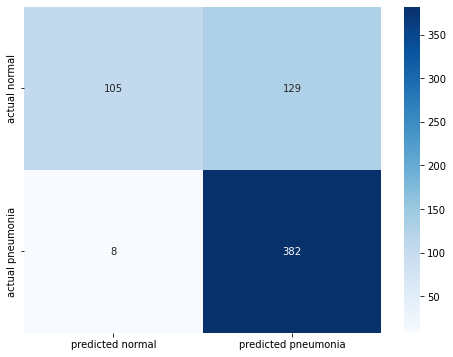

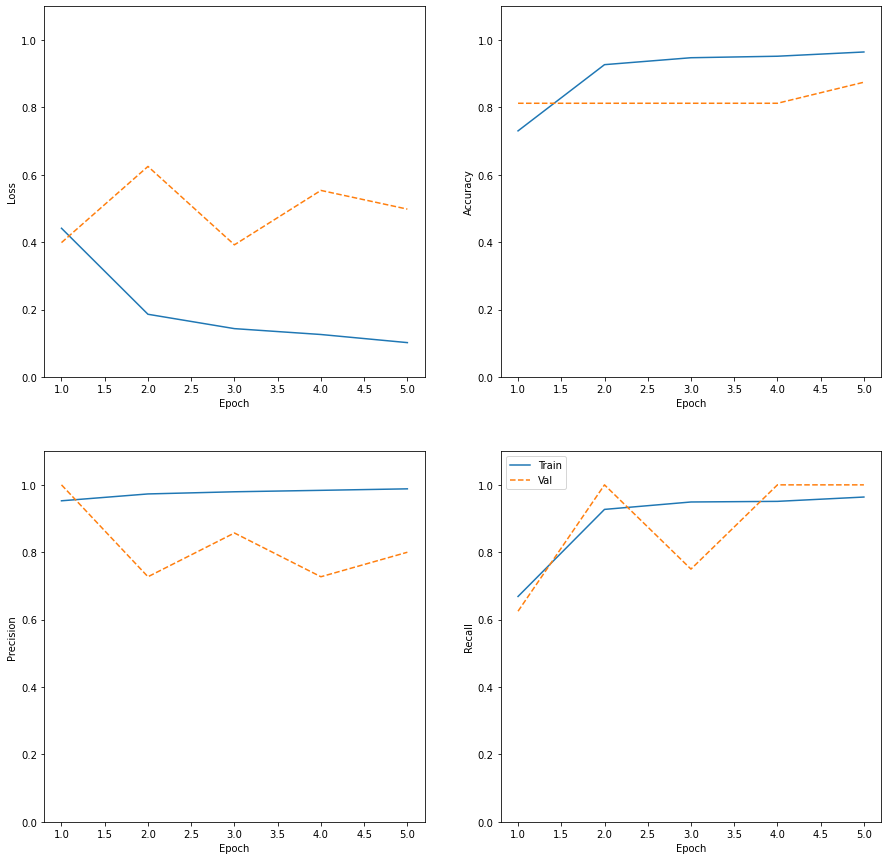

In [55]:
full_report(cnn_model_v7, cnn_model_v7_results)

## CNN model v8


Same model as version 7 with decreased batch size

In [56]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v8 = make_cnn_model()
cnn_model_v8.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 30, 30, 32)     

In [58]:
cnn_model_v8_results = cnn_model_v8.fit(X_train, y_train,
                                        batch_size=64,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 0.3418 - tp: 2994.0000 - fp: 141.0000 - tn: 1208.0000 - fn: 831.0000 - accuracy: 0.8121 - precision: 0.9550 - recall: 0.7827 - auc: 0.9316 - prc: 0.9733
Epoch 1: val_loss did not improve from 0.27397
81/81 [==============================] - 84s 1s/step - loss: 0.3418 - tp: 2994.0000 - fp: 141.0000 - tn: 1208.0000 - fn: 831.0000 - accuracy: 0.8121 - precision: 0.9550 - recall: 0.7827 - auc: 0.9316 - prc: 0.9733 - val_loss: 0.9054 - val_tp: 8.0000 - val_fp: 6.0000 - val_tn: 2.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.8750 - val_prc: 0.8914
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 0.1426 - tp: 3612.0000 - fp: 70.0000 - tn: 1271.0000 - fn: 205.0000 - accuracy: 0.9467 - precision: 0.9810 - recall: 0.9463 - auc: 0.9869 - prc: 0.9950
Epoch 2: val_loss did not improve from 0.27397
81/81 [==============================] - 90s 1s/step - l

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.91      0.56      0.69       234
   pneumonia       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



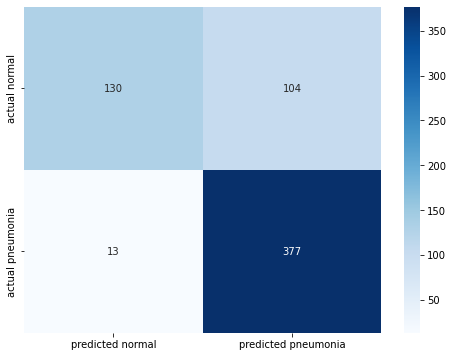

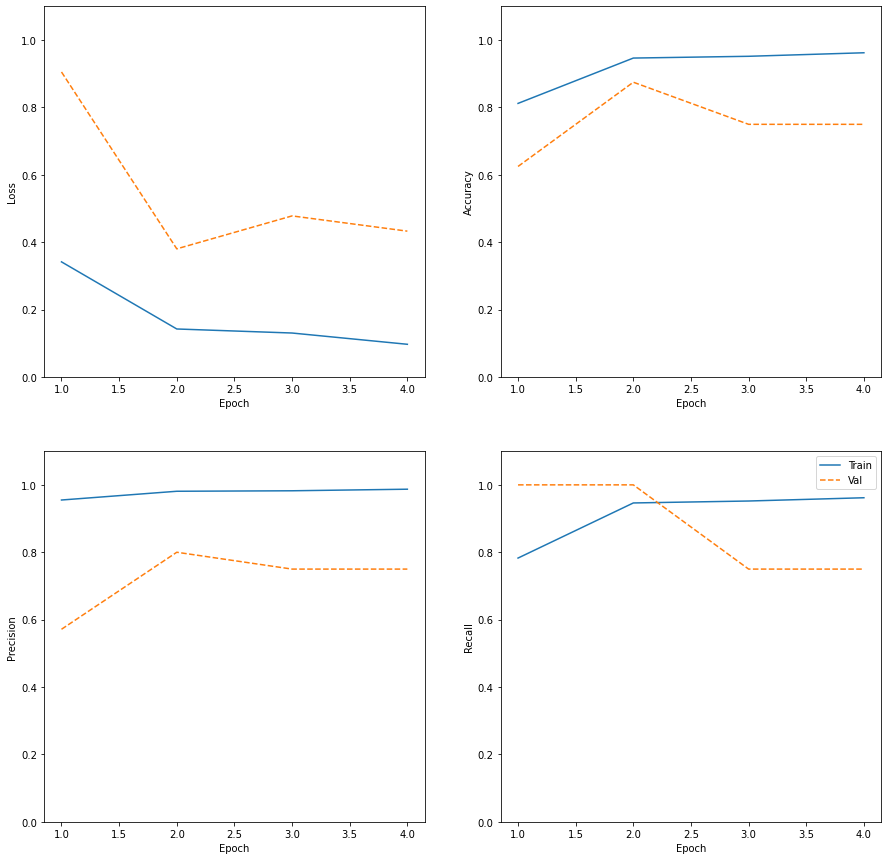

In [59]:
full_report(cnn_model_v8, cnn_model_v8_results)

## CNN model v9

Version 8 was the best one yet! Increase in total accuracy to 81%. It does come with a cost of increasing type II errors. Lets increase the batch size to double what we used in version 7

In [60]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v9 = make_cnn_model()
cnn_model_v9.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 30, 30, 32)     

In [62]:
cnn_model_v9_results = cnn_model_v9.fit(X_train, y_train,
                                        batch_size=256,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.5939 - tp: 2105.0000 - fp: 239.0000 - tn: 1110.0000 - fn: 1720.0000 - accuracy: 0.6214 - precision: 0.8980 - recall: 0.5503 - auc: 0.7868 - prc: 0.8991
Epoch 1: val_loss did not improve from 0.27397
21/21 [==============================] - 83s 4s/step - loss: 0.5939 - tp: 2105.0000 - fp: 239.0000 - tn: 1110.0000 - fn: 1720.0000 - accuracy: 0.6214 - precision: 0.8980 - recall: 0.5503 - auc: 0.7868 - prc: 0.8991 - val_loss: 1.0723 - val_tp: 8.0000 - val_fp: 6.0000 - val_tn: 2.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.8906 - val_prc: 0.9186
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.3156 - tp: 3347.0000 - fp: 196.0000 - tn: 1145.0000 - fn: 470.0000 - accuracy: 0.8709 - precision: 0.9447 - recall: 0.8769 - auc: 0.9401 - prc: 0.9761
Epoch 2: val_loss did not improve from 0.27397
21/21 [==============================] - 86s 4s/step 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.93      0.29      0.44       234
   pneumonia       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.81      0.64      0.63       624
weighted avg       0.78      0.72      0.68       624



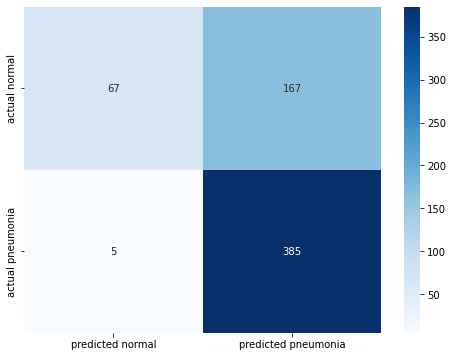

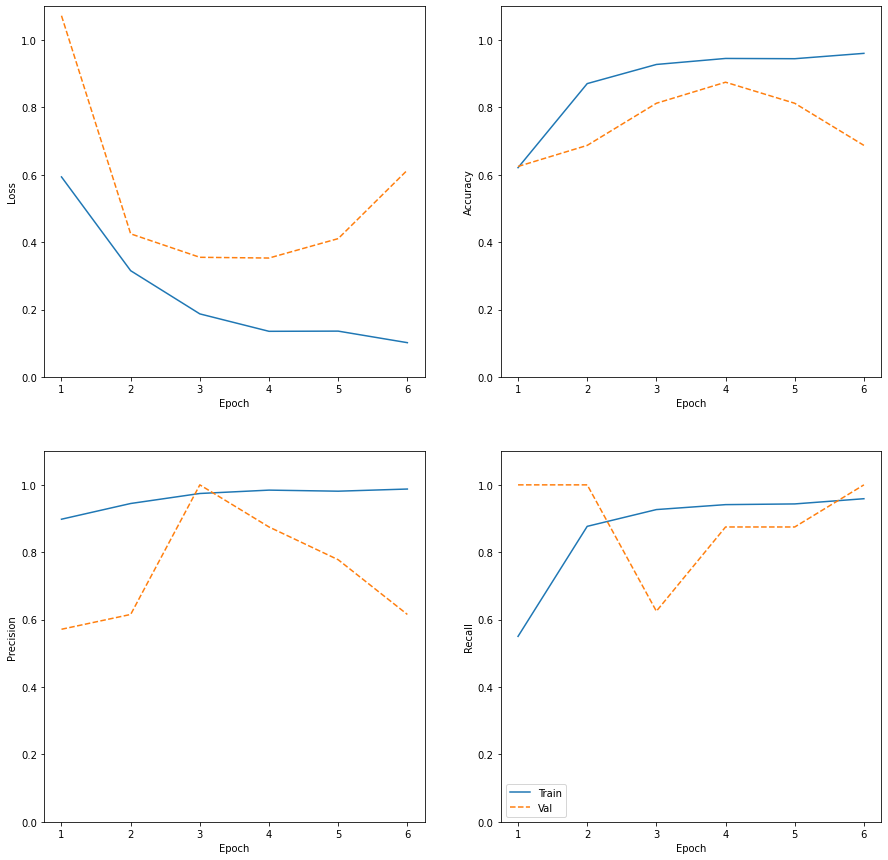

In [63]:
full_report(cnn_model_v9, cnn_model_v9_results)

## CNN model v10

We are going to take version 8 and increase the complexity of our model. We will leave the same number of convolution layers but increase the filters on each layer by double.

In [64]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v10 = make_cnn_model()
cnn_model_v10.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 30, 30, 64)     

In [65]:
cnn_model_v10_results = cnn_model_v10.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.4384 - tp: 2743.0000 - fp: 204.0000 - tn: 1145.0000 - fn: 1082.0000 - accuracy: 0.7514 - precision: 0.9308 - recall: 0.7171 - auc: 0.8776 - prc: 0.9481
Epoch 1: val_loss did not improve from 0.27397
41/41 [==============================] - 161s 4s/step - loss: 0.4384 - tp: 2743.0000 - fp: 204.0000 - tn: 1145.0000 - fn: 1082.0000 - accuracy: 0.7514 - precision: 0.9308 - recall: 0.7171 - auc: 0.8776 - prc: 0.9481 - val_loss: 0.9076 - val_tp: 8.0000 - val_fp: 5.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - val_auc: 0.9141 - val_prc: 0.9249
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1635 - tp: 3575.0000 - fp: 82.0000 - tn: 1259.0000 - fn: 242.0000 - accuracy: 0.9372 - precision: 0.9776 - recall: 0.9366 - auc: 0.9833 - prc: 0.9936
Epoch 2: val_loss did not improve from 0.27397
41/41 [==============================] - 153s 4s/step

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.92      0.46      0.61       234
   pneumonia       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



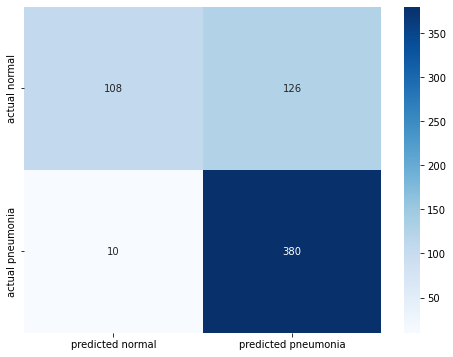

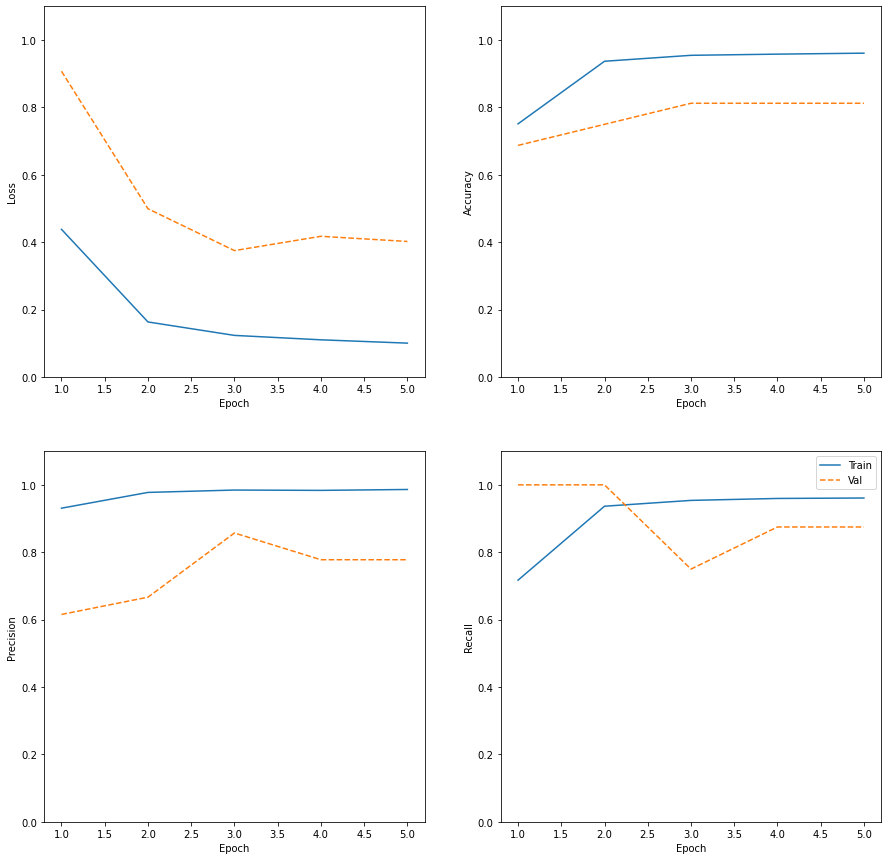

In [66]:
full_report(cnn_model_v10, cnn_model_v10_results)

## CNN model v11 -  current best overall accuracy

Still not too much improvement off our best model, lets add one more layer of convolution with 32 filters to our model v8.

In [67]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v11 = make_cnn_model()
cnn_model_v11.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 30, 30, 32)     

In [68]:
cnn_model_v11_results = cnn_model_v11.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.6069 - tp: 1824.0000 - fp: 223.0000 - tn: 1126.0000 - fn: 2001.0000 - accuracy: 0.5702 - precision: 0.8911 - recall: 0.4769 - auc: 0.7628 - prc: 0.8878
Epoch 1: val_loss did not improve from 0.27397
41/41 [==============================] - 80s 2s/step - loss: 0.6069 - tp: 1824.0000 - fp: 223.0000 - tn: 1126.0000 - fn: 2001.0000 - accuracy: 0.5702 - precision: 0.8911 - recall: 0.4769 - auc: 0.7628 - prc: 0.8878 - val_loss: 0.6068 - val_tp: 8.0000 - val_fp: 7.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - val_auc: 0.9688 - val_prc: 0.9737
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.2716 - tp: 3444.0000 - fp: 136.0000 - tn: 1205.0000 - fn: 373.0000 - accuracy: 0.9013 - precision: 0.9620 - recall: 0.9023 - auc: 0.9584 - prc: 0.9834
Epoch 2: val_loss did not improve from 0.27397
41/41 [==============================] - 78s 2s/step 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.85      0.62      0.72       234
   pneumonia       0.80      0.94      0.86       390

    accuracy                           0.82       624
   macro avg       0.83      0.78      0.79       624
weighted avg       0.82      0.82      0.81       624



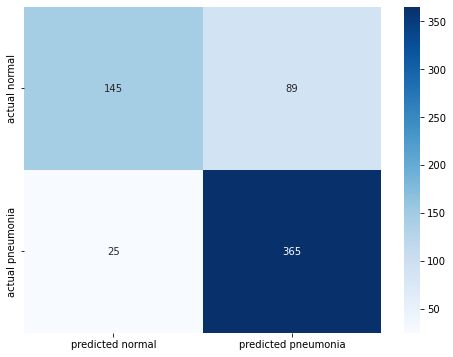

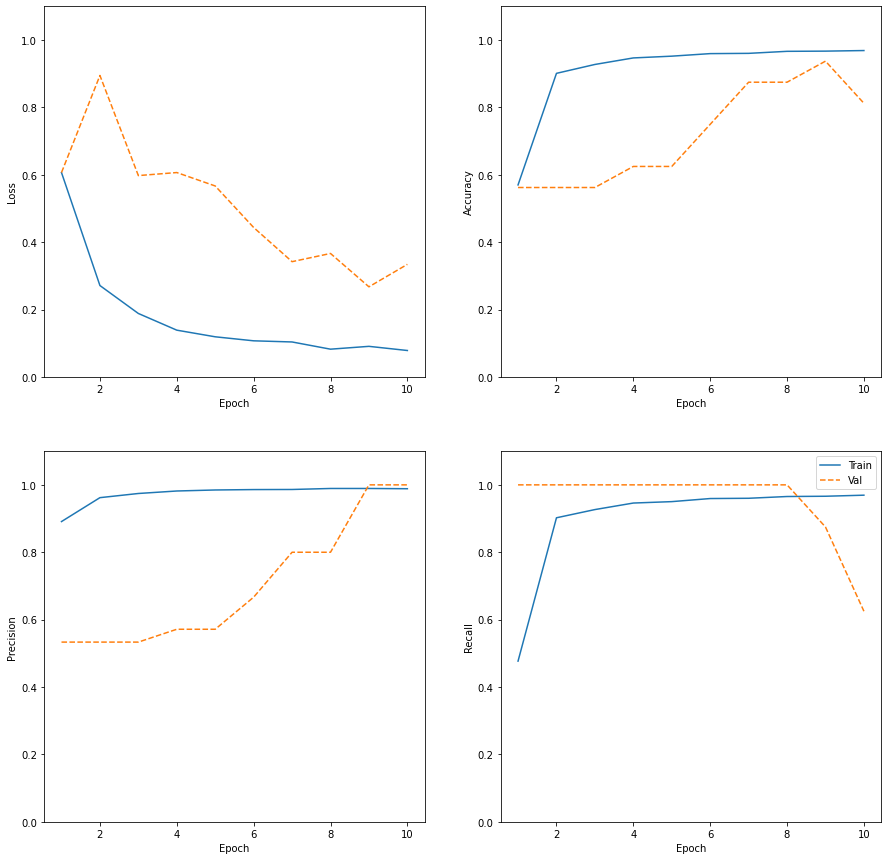

In [69]:
full_report(cnn_model_v11, cnn_model_v11_results)

In [97]:
cnn_model_v11.save(filepath="./models/")

INFO:tensorflow:Assets written to: ./models/assets


## CNN model v12 (11.1)

Version 11 was pretty good, and our early stopping callback was not triggered. Lets run it for more epochs to see if we can get a new best model.

In [82]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v12 = make_cnn_model()
cnn_model_v12.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 30, 30, 32)     

In [83]:
cnn_model_v12_results = cnn_model_v12.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/25
41/41 [==============================] - ETA: 0s - loss: 0.4843 - tp: 2306.0000 - fp: 192.0000 - tn: 1157.0000 - fn: 1519.0000 - accuracy: 0.6693 - precision: 0.9231 - recall: 0.6029 - auc: 0.8660 - prc: 0.9432
Epoch 1: val_loss did not improve from 0.26776
41/41 [==============================] - 111s 3s/step - loss: 0.4843 - tp: 2306.0000 - fp: 192.0000 - tn: 1157.0000 - fn: 1519.0000 - accuracy: 0.6693 - precision: 0.9231 - recall: 0.6029 - auc: 0.8660 - prc: 0.9432 - val_loss: 0.3761 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 6.0000 - val_fn: 1.0000 - val_accuracy: 0.8125 - val_precision: 0.7778 - val_recall: 0.8750 - val_auc: 0.9062 - val_prc: 0.9444
Epoch 2/25
41/41 [==============================] - ETA: 0s - loss: 0.1694 - tp: 3537.0000 - fp: 77.0000 - tn: 1264.0000 - fn: 280.0000 - accuracy: 0.9308 - precision: 0.9787 - recall: 0.9266 - auc: 0.9820 - prc: 0.9934
Epoch 2: val_loss did not improve from 0.26776
41/41 [==============================] - 101s 2s/step - l

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.85      0.50      0.63       234
   pneumonia       0.76      0.95      0.84       390

    accuracy                           0.78       624
   macro avg       0.81      0.72      0.73       624
weighted avg       0.79      0.78      0.76       624



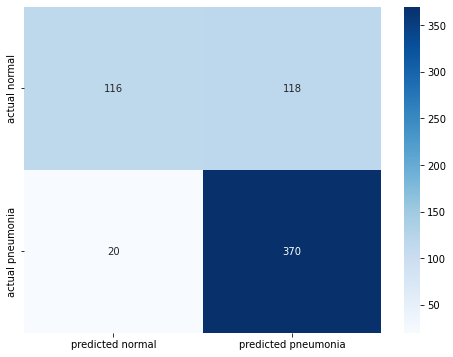

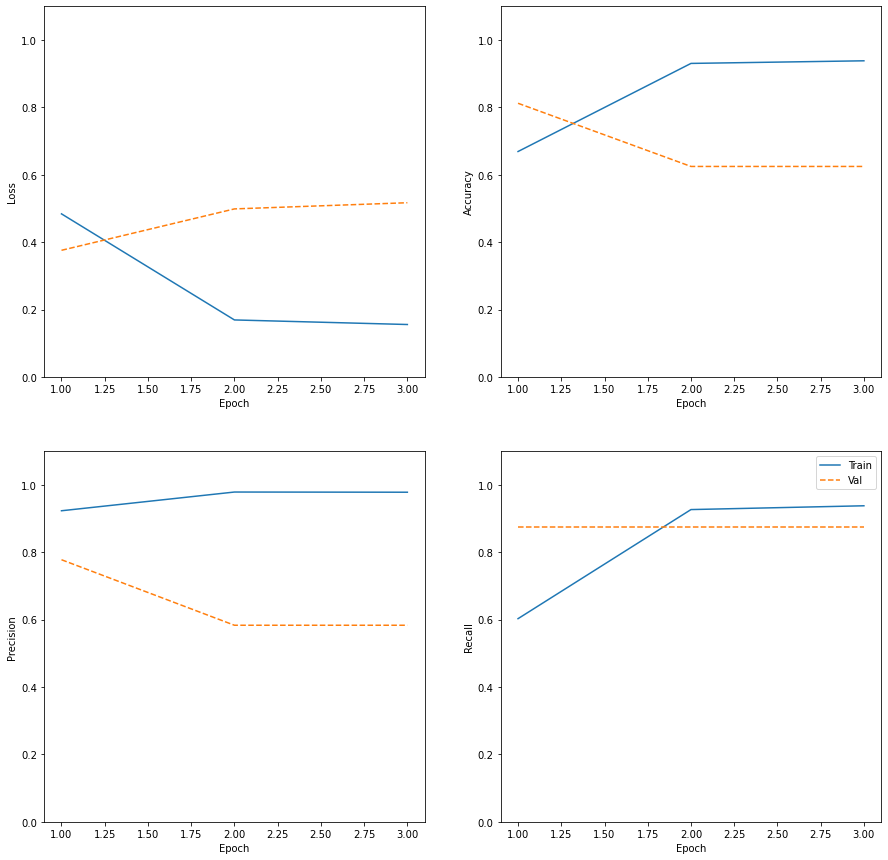

In [84]:
full_report(cnn_model_v12, cnn_model_v12_results)

## CNN model v13 (11.2)

Lets try increasing the value of each layers filter by double.

In [85]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model


cnn_model_v13 = make_cnn_model()
cnn_model_v13.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 30, 30, 64)     

In [86]:
cnn_model_v13_results = cnn_model_v13.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/25
41/41 [==============================] - ETA: 0s - loss: 0.5645 - tp: 1799.0000 - fp: 165.0000 - tn: 1184.0000 - fn: 2026.0000 - accuracy: 0.5765 - precision: 0.9160 - recall: 0.4703 - auc: 0.8053 - prc: 0.9129
Epoch 1: val_loss did not improve from 0.26776
41/41 [==============================] - 167s 4s/step - loss: 0.5645 - tp: 1799.0000 - fp: 165.0000 - tn: 1184.0000 - fn: 2026.0000 - accuracy: 0.5765 - precision: 0.9160 - recall: 0.4703 - auc: 0.8053 - prc: 0.9129 - val_loss: 0.3780 - val_tp: 7.0000 - val_fp: 3.0000 - val_tn: 5.0000 - val_fn: 1.0000 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750 - val_auc: 0.9219 - val_prc: 0.9500
Epoch 2/25
41/41 [==============================] - ETA: 0s - loss: 0.2256 - tp: 3485.0000 - fp: 114.0000 - tn: 1227.0000 - fn: 332.0000 - accuracy: 0.9135 - precision: 0.9683 - recall: 0.9130 - auc: 0.9701 - prc: 0.9891
Epoch 2: val_loss did not improve from 0.26776
41/41 [==============================] - 164s 4s/step - 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.82      0.63      0.71       234
   pneumonia       0.81      0.92      0.86       390

    accuracy                           0.81       624
   macro avg       0.81      0.77      0.79       624
weighted avg       0.81      0.81      0.80       624



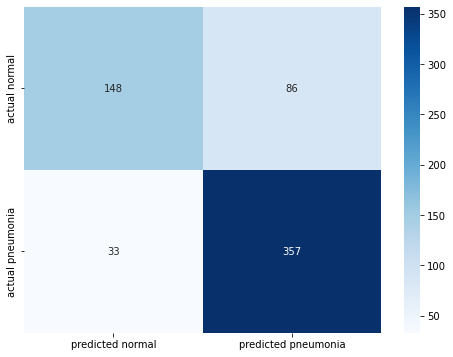

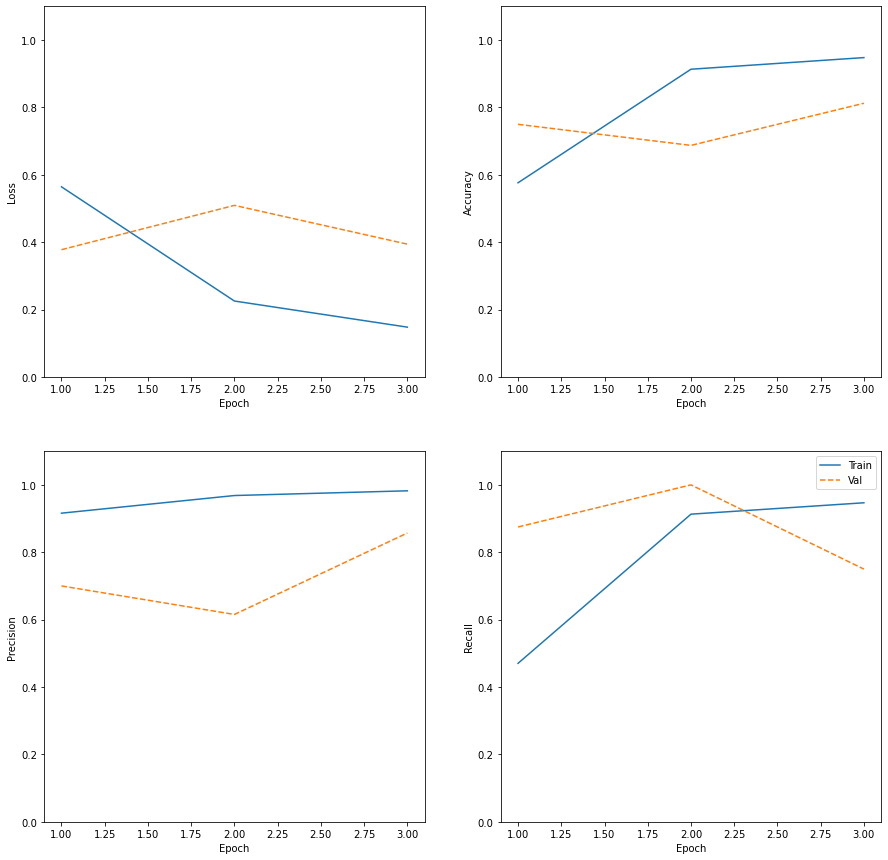

In [87]:
full_report(cnn_model_v13, cnn_model_v13_results)

## CNN model v14 (11.3)

We realized that we defined the input shape on the 2nd layer, lets run it again.

In [89]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v14 = make_cnn_model()
cnn_model_v14.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 30, 30, 64)     

In [90]:
cnn_model_v14_results = cnn_model_v14.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/25
41/41 [==============================] - ETA: 0s - loss: 0.3967 - tp: 3078.0000 - fp: 270.0000 - tn: 1079.0000 - fn: 747.0000 - accuracy: 0.8034 - precision: 0.9194 - recall: 0.8047 - auc: 0.9021 - prc: 0.9608
Epoch 1: val_loss did not improve from 0.26776
41/41 [==============================] - 156s 4s/step - loss: 0.3967 - tp: 3078.0000 - fp: 270.0000 - tn: 1079.0000 - fn: 747.0000 - accuracy: 0.8034 - precision: 0.9194 - recall: 0.8047 - auc: 0.9021 - prc: 0.9608 - val_loss: 0.9668 - val_tp: 8.0000 - val_fp: 7.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - val_auc: 0.8906 - val_prc: 0.9396
Epoch 2/25
41/41 [==============================] - ETA: 0s - loss: 0.1852 - tp: 3529.0000 - fp: 86.0000 - tn: 1255.0000 - fn: 288.0000 - accuracy: 0.9275 - precision: 0.9762 - recall: 0.9245 - auc: 0.9788 - prc: 0.9918
Epoch 2: val_loss did not improve from 0.26776
41/41 [==============================] - 144s 4s/step -

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.89      0.41      0.57       234
   pneumonia       0.73      0.97      0.84       390

    accuracy                           0.76       624
   macro avg       0.81      0.69      0.70       624
weighted avg       0.79      0.76      0.73       624



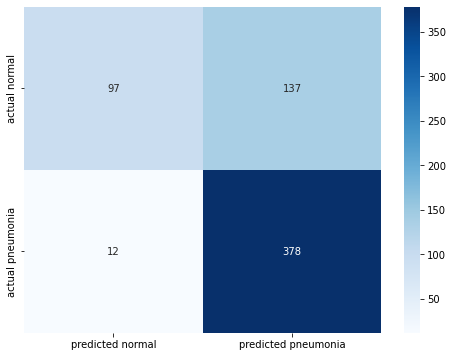

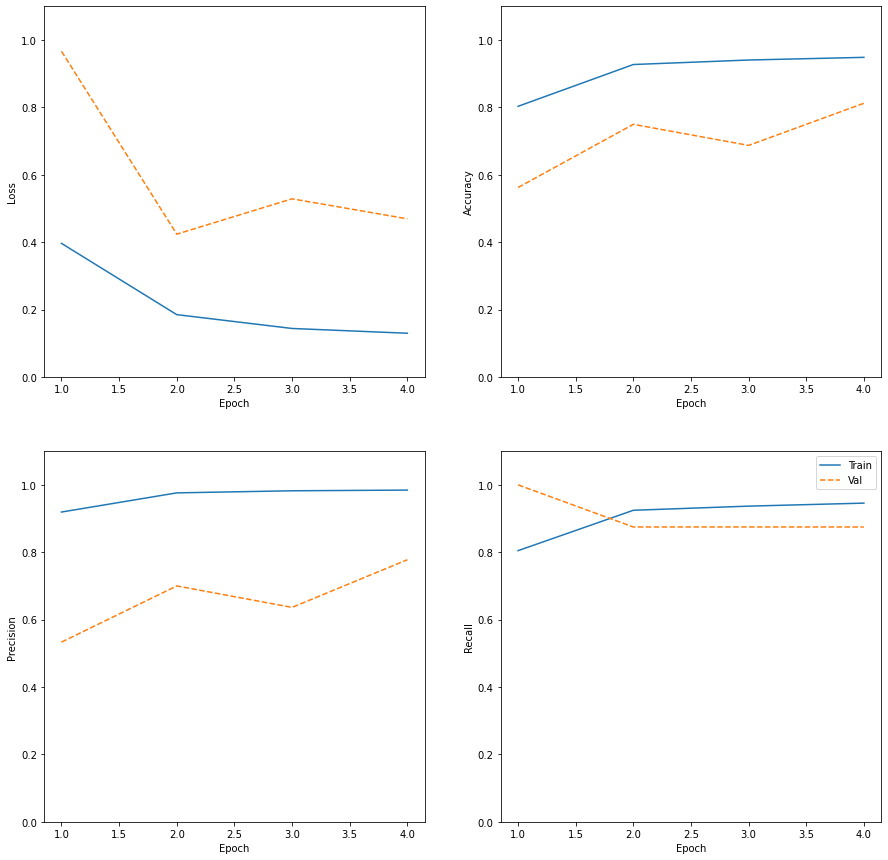

In [93]:
full_report(cnn_model_v14, cnn_model_v14_results)

## CNN model v15 (11.4)

We are still overfitting, so lets add some dropout to our version 11 model.

In [94]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION, input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(16, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, (3,3), activation=ACTIVATION))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3,3), activation=ACTIVATION))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=ACTIVATION))
    
    model.add(Dense(1, activation=OUTPUT))
    
    model.compile(loss=LOSS,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

    return model

cnn_model_v15 = make_cnn_model()
cnn_model_v15.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_102 (Conv2D)         (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 62, 62, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 16)      

In [95]:
cnn_model_v15_results = cnn_model_v15.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=CALLBACKS,
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/25
41/41 [==============================] - ETA: 0s - loss: 0.5901 - tp: 3134.0000 - fp: 585.0000 - tn: 764.0000 - fn: 691.0000 - accuracy: 0.7534 - precision: 0.8427 - recall: 0.8193 - auc: 0.7684 - prc: 0.9010
Epoch 1: val_loss did not improve from 0.26776
41/41 [==============================] - 101s 2s/step - loss: 0.5901 - tp: 3134.0000 - fp: 585.0000 - tn: 764.0000 - fn: 691.0000 - accuracy: 0.7534 - precision: 0.8427 - recall: 0.8193 - auc: 0.7684 - prc: 0.9010 - val_loss: 0.4555 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 6.0000 - val_fn: 1.0000 - val_accuracy: 0.8125 - val_precision: 0.7778 - val_recall: 0.8750 - val_auc: 0.8906 - val_prc: 0.9277
Epoch 2/25
41/41 [==============================] - ETA: 0s - loss: 0.2644 - tp: 3377.0000 - fp: 133.0000 - tn: 1208.0000 - fn: 440.0000 - accuracy: 0.8889 - precision: 0.9621 - recall: 0.8847 - auc: 0.9571 - prc: 0.9842
Epoch 2: val_loss did not improve from 0.26776
41/41 [==============================] - 98s 2s/step - loss:

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.88      0.48      0.62       234
   pneumonia       0.76      0.96      0.85       390

    accuracy                           0.78       624
   macro avg       0.82      0.72      0.74       624
weighted avg       0.80      0.78      0.76       624



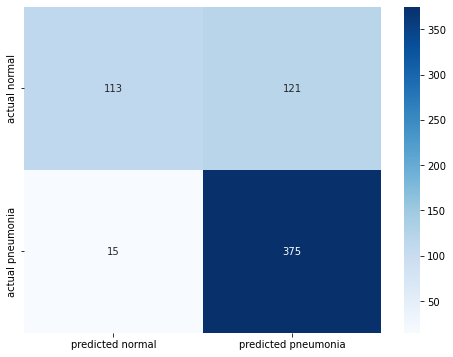

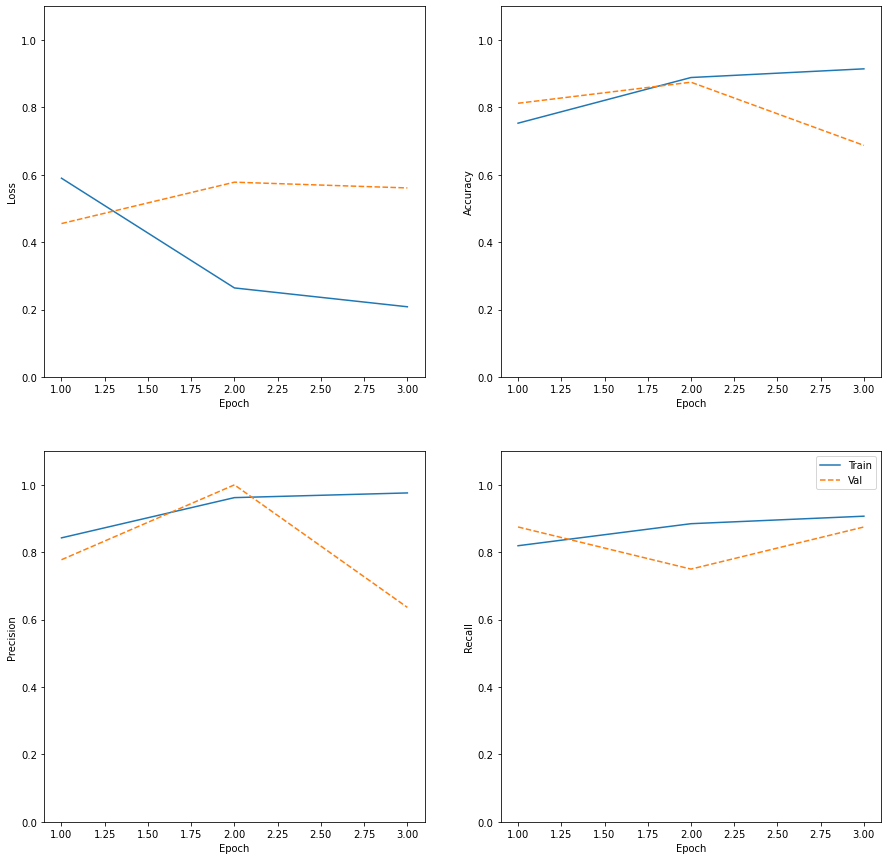

In [96]:
full_report(cnn_model_v15, cnn_model_v15_results)

# Xception

### Setting up data

The Xception pretrained model requires that our images be (299, 299, 3)

In [ ]:
folder_names = ['train', 'test', 'val']
label_names = ['NORMAL', 'PNEUMONIA']

all_images = []

# loop through the different combinations of folder name prefixes
for folder in folder_names:
    for label in label_names:
        # set up the path to each folder of images
        path = f'./chest_xray/{folder}/{label}'
        # create a list of the filenames in that directory
        filelist = list(listdir(path))
        # loop through each file in the folder
        for file_name in filelist:
            # set the filepath for the file in question
            filepath = path + r'/' + file_name
            # open the image
            image = Image.open(filepath).convert('RGB')
            # drop all images with height lower than 299
            if image.height < 299:
                continue    
            # resize and crop the image to 299x299
            new_image = resize_and_crop(image, new_size=299)
            # convert the image into an array
            image_array = np.asarray(new_image)
            # append all the image information to the list of images
            all_images.append((folder, label, image_array))

# set the column names
column_names = ['folder', 'label', 'image_array']
# convert the list of images to a dataframe
all_images_df = pd.DataFrame(all_images, columns=column_names)

In [ ]:
def create_target(df):
    if df.label == 'PNEUMONIA':
        return 1
    else:
        return 0
    
all_images_df['target'] = all_images_df.apply(create_target, axis=1)

In [ ]:
train_df = all_images_df[all_images_df.folder == 'train'][['image_array', 'target']]
test_df = all_images_df[all_images_df.folder == 'test'][['image_array', 'target']]
val_df = all_images_df[all_images_df.folder == 'val'][['image_array', 'target']]

In [ ]:
len(train_df)

In [ ]:
train_df.iloc[0]['image_array'].shape

In [ ]:
X_train = np.array(train_df.image_array.values.tolist())
y_train = np.asarray(train_df.target)

X_test = np.array(test_df.image_array.values.tolist())
y_test = np.asarray(test_df.target)

X_val = np.array(val_df.image_array.values.tolist())
y_val = np.asarray(val_df.target)

# helper function to shuffle data/target in the same way
def shuffle_arrays(data, target):
    assert len(data) == len(target)
    p = np.random.permutation(len(data))
    return data[p], target[p]
# shuffle all data
X_train, y_train = shuffle_arrays(X_train, y_train)
X_val, y_val = shuffle_arrays(X_val, y_val)
X_test, y_test = shuffle_arrays(X_test, y_test)

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")

In [ ]:
X_groups = ['X_train', 'X_val', 'X_test']

for data in X_groups:
    new_var = f"{data}_xc"
    globals()[new_var] = keras.applications.xception.preprocess_input(globals()[data])
    
# verify shapes are accurate
print(f"Train data/target shapes: {X_train_xc.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test_xc.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val_xc.shape}, {y_val.shape}")

## Xception model v1

In [ ]:
Xception_v1 = keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
y_pred = converted_ypred(Xception_v1, X_val_xc)

In [ ]:
y_pred

In [ ]:
model_report(y_val, y_pred)